(c) 2023 Manuel Razo. This work is licensed under a [Creative Commons
Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
All code contained herein is licensed under an [MIT
license](https://opensource.org/licenses/MIT).

In [99]:
# Load project package
@load_pkg BayesFitness

import Revise
# Import project package
import BayesFitness

# Import package to handle DataFrames
import DataFrames as DF
import CSV
import XLSX

# Import basic statistical functions
import StatsBase

# Import library to list files
import Glob

# Load CairoMakie for plotting
using CairoMakie
import ColorSchemes
import Makie
# Activate backend
CairoMakie.activate!()

# Set PBoC Plotting style
BayesFitness.viz.pboc_makie!()

# Data Wrangling for #BigBatch

In this notebook we will turn the raw barcode counts from the `BigBatch`
experiment into a tidy data frame. Let's begin by loading the raw `.csv` file.

In [4]:
# Load CSV file
df = CSV.read("$(git_root())/data/big_batch/bc_counts.csv", DF.DataFrame)

first(df, 5)

Row,BCID_x,Batch2_2Day_1.8Baffle-R1-T4,Batch3_2Day_NS-R2-T1,Batch1_1Day_32-R2-T1_reprep,Batch2_Salt_1.4Baffle-R1-T4,Batch1_Salt_32Baffle-R1-T1,Batch3_1Day_SucBaffle-R1-T3,Batch2_Salt_1.4-R2-T4,Batch2_2Day_1.4-R2-T2,Batch3_Salt_Raf-R2-T1,Batch3_Salt_M3-R2-T2,Batch1_1Day_28-R1-T3,Batch4_2Day_10uM_H89-R1-T2,Batch2_Salt_1.4-R1-T3,Batch4_1Day_0.5%EtOH-R1-T1,Batch4_Salt_10uM_Paromomycin-R2-T2,Batch4_1Day_10uM_Paromomycin-R1-T4,Batch1_1Day_32Baffle-R2-T3_reprep,Batch4_2Day_50uM_Paromomycin-R2-T3,Batch1_Salt_30Baffle-R1-T3,Batch4_2Day_M3-R1-T3,Batch1_Salt_30Baffle-R2-T1,Batch1_1Day_28-R1-T1,Batch2_Salt_1.5-R1-T1,Batch3_Salt_M3-R1-T1,Batch4_1Day_0.5%EtOH-R1-T3,Batch3_1Day_Raf-R1-T3,Batch3_1Day_SucBaffle-R1-T4,Batch3_Salt_RafBaffle-R1-T3,Batch2_1Day-T0,Batch1_2Day-T0_reprep,Batch4_Salt_10uM_Paromomycin-R1-T4,Batch1_2Day_32Baffle-R2-T1,Batch4_1Day_10uM_Paromomycin-R2-T4,Batch3_1Day_Suc-R2-T2,Batch3_2Day_ANC-T3,Batch4_1Day_4uM_H89-R2-T4,Batch3_Salt_SucBaffle-R1-T1,Batch3_Salt_NS-R1-T3,Batch3_Salt_Suc-R1-T1,Batch1_2Day_32-R2-T2,Batch3_2Day_M3-R2-T2,Batch2_2Day_1.5-R2-T2,Batch2_2Day_1.4-R1-T3,Batch1_1Day_30Baffle-R2-T4_reprep,Batch1_1Day_32-R1-T3_PCRb,Batch1_2Day_28-R1-T1,Batch3_1Day_Suc-R1-T1,Batch2_Salt_1.5-R1-T2,Batch1_1Day_32Baffle-R1-T1_reprep,Batch1_1Day_30Baffle-R1-T1_reprep,Batch4_2Day_0.5%EtOH-R2-T3,Batch1_1Day_30Baffle-R2-T3_reprep,Batch1_Salt_30-R1-T4,Batch1_1Day_32-R2-T2,Batch1_1Day_30-R1-T4,Batch3_1Day_NS-R1-T1,Batch1_Salt_32-R1-T2,Batch1_2Day_30-R1-T4,Batch4_Salt_M3-R2-T3,Batch4_2Day_50uM_Paromomycin-R2-T2,Batch3_1Day_NS-R2-T4,Batch1_1Day_32Baffle-R2-T1,Batch4_Salt_M3-R1-T1,Batch1_1Day_30-R1-T3,Batch1_2Day_32-R2-T3,Batch3_2Day_Suc-R2-T3,Batch1_2Day_30Baffle-R2-T3_reprep,Batch1_2Day_32-R2-T4_reprep,Batch3_Salt_Suc-R2-T2,Batch1_2Day_32-R1-T3_reprep,Batch1_2Day-T0,Batch1_2Day_30Baffle-R2-T3,Batch3_Salt_SucBaffle-R2-T3,Batch1_Salt_30Baffle-R1-T4,Batch1_2Day_32Baffle-R1-T2_reprep,Batch1_1Day_32-R2-T2_PCRb,Batch4_Salt_4uM_H89-R1-T4,Batch4_Salt_10uM_H89-R2-T2,Batch2_Salt_1.4Baffle-R2-T1,Batch1_2Day_28-R1-T2_reprep,Batch4_Salt_50uM_Paromomycin-R2-T4,Batch2_1Day_1.8Baffle-R1-T1,Batch1_1Day_30Baffle-R2-T3_PCRb,Batch4_2Day_0.5%EtOH-R2-T1,Batch1_Salt_32Baffle-R2-T3,Batch4_1Day_10uM_H89-R2-T4,Batch4_Salt_10uM_Paromomycin-R1-T1,Batch4_Salt_10uM_H89-R2-T3,Batch2_1Day_1.8-R1-T4,Batch4_Salt_50uM_Paromomycin-R2-T1,Batch1_2Day_28-R2-T4_reprep,Batch3_1Day_M3-R1-T4,Batch4_Salt_4uM_H89-R2-T3,Batch1_1Day_30Baffle-R2-T1_reprep,Batch1_2Day_30-R1-T3_reprep,Batch4_1Day_10uM_H89-R1-T3,Batch2_Salt_1.4Baffle-R1-T2,Batch1_1Day_28-R1-T4_PCRb,Batch1_2Day_30Baffle-R2-T4_reprep,⋯
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,⋯
1,0,277,9,1,9,152,2136,72,1477,385,789,0,9175,571,37,426,8355,39,8194,12,24274,227,0,387,634,2092,783,830,422,0,0,41,0,434,395,2,2147,498,7934,186,4,1002,961,1531,65,106,0,236,768,4,3,13581,115,175,0,0,112,272,16,259,3421,3078,0,283,2,2,124,77,16022,788,7163,0,18,849,10,6073,21,590,263,348,13,275,414,92,887,29,2088,461,102,3152,424,121,665,246,4,86,2062,373,36,150,⋯
2,1,248213,396,1398,137998,20929,114761,57731,93667,9514,124199,0,734493,167669,1589,47118,352180,21775,2624451,28334,1768511,23738,0,24964,11451,132137,27460,70604,39333,3,0,18269,96,27957,11615,730,124727,16577,68280,4822,463,51115,56965,103358,6564,4929,18,5416,133263,1002,871,1347370,61385,112556,0,104,1674,82800,2445,31575,827935,71486,6,15120,11,295,11275,43300,1112297,35750,565815,3,9025,72408,28424,1011972,837,115446,22199,2

The columns with the barcode count are of the form
`Batch2_2Day_1.8Baffle-R1-T4`, where the information content is displayed as
follows:
- `Batch2`: Batch number
- `2Day`: Cycle length
- `1.8Baffle`: Condition
- `R1`: Replica 1
- `T4`: Time point 4

There might be multiple columns with this name, depending on how many times this
sample was sequenced. Therefore, we will focus on the ones that contain
`_combined` since they congregate counts from all sequencing and re-sequencing
runs.

In [125]:
# Filter columns with `_combined` in the name
df_filt = df[:, 
            .!(.!(occursin.("_combined", names(df))) .& 
            (occursin.("Batch", names(df))))]

# Locate columns with barcode counts
bc_cols = names(df_filt)[occursin.("Batch", names(df_filt))]

# Transform dataframe into tidy format
df_tidy = DF.stack(df_filt, bc_cols)

# Rename columns
DF.rename!(df_tidy, Dict(:value => :count, :variable => :name))

first(df_tidy, 5)

Row,BCID_x,bc_merged,barcode,barcode_lowcomplexity,barcode_highcomplexity,BCID_y,barcode_fasta,source_publication,cloneID,cloneID_new,evolution_condition,ancestor,class,ploidy,ploidy_new,gene,type,additional_muts,1D_Fitness_Li2019,1D_Error_Li2019,2D_Fitness_Li2019,2D_Error_Li2019,3D_Fitness_Li2019,3D_Error_Li2019,5D_Fitness_Li2019,5D_Error_Li2019,FerPerHour_Li2019,ResPerHour_Li2019,StaPerHour_Li2019,name,count
,Int64,String,String,String31,String,Int64,String,String15,String31,String?,String7,String15,String31,String15,String15,String31,String?,String?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,String,Int64
1,0,GAGTGAAACATGAATGGTATTCATCATGATCAATCTACAAAAATATTTAATG,TGATCAATCTACAAAAATATTTAATG_GAGTGAAACATGAATGGTATTCATCA,TGATCAATCTACAAAAATATTTAATG,GAGTGAAACATGAATGGTATTCATCA,0,GAGTGAAACATGAATGGTATTCATCATGATCAATCTACAAAAATATTTAATG,This_study,missing,EVO2D_IRA1_MIS_rearray_Plate1-A1,Evo2D,IRA1_MIS,missing,missing,diploid,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,53
2,1,ACTCTAACGTGTAACTAATTTTGAGTCCGCCAATCCCGAACCCCGTTTCGCC,CCGCCAATCCCGAACCCCGTTTCGCC_ACTCTAACGTGTAACTAATTTTGAGT,CCGCCAATCCCGAACCCCGTTTCGCC,ACTCTAACGTGTAACTAATTTTGAGT,1,ACTCTAACGTGTAACTAATTTTGAGTCCGCCAATCCCGAACCCCGTTTCGCC,Aggeli2020,gpb2_evo1_plate9_H8,gpb2_evo1_plate9_H8,Evo2D,GPB2,adaptive_haploids,Haploid,Haploid,missing,Other,DOP1-NON_SYNONYMOUS_CODING; SMD2-NON_SYNONYMOUS_CODING; YDL180W-DOWNSTREAM; LAS21-UPSTREAM,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,1213
3,2,ATGGGAACACGGAATGATCTTTTATTGACAGAAAAGCCAAATGGATTTACCG,GACAGAAAAGCCAAATGGATTTACCG_ATGGGAACACGGAATGATCTTTTATT,GACAGAAAAGCCAAATGGATTTACCG,ATGGGAACACGGAATGATCTTTTATT,2,ATGGGAACACGGAATGATCTTTTATTGACAGAAAAGCCAAATGGATTTACCG,This_study,missing,EVO3D_TCG_rearray_Plate1-A4,Evo3D,CYR1,missing,missing,diploid,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,17
4,3,TACTAAATAAGTAAGGGAATTCTGTTCCAACAAAACACAAATCTGTTGTGTA,CCAACAAAACACAAATCTGTTGTGTA_TACTAAATAAGTAAGGGAATTCTGTT,CCAACAAAACACAAATCTGTTGTGTA,TACTAAATAAGTAAGGGAATTCTGTT,3,TACTAAATAAGTAAGGGAATTCTGTTCCAACAAAACACAAATCTGTTGTGTA,This_study,missing,EVO2D_IRA1_NON_rearray_Plate1-A1,Evo2D,IRA1_NON,missing,missing,diploid,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,19
5,4,ATGACAAACTTTAAATAATTTAATTGTATCGAAACCCAAAGAGATTTAATCG,TATCGAAACCCAAAGAGATTTAATCG_ATGACAAACTTTAAATAATTTAATTG,TATCGAAACCCAAAGAGATTTAATCG,ATGACAAACTTTAAATAATTTAATTG,4,ATGACAAACTTTAAATAATTTAATTGTATCGAAACCCAAAGAGATTTAATCG,This_study,missing,EVO3D_IRA1_MIS_rearray_Plate1-C4,Evo3D,IRA1_MIS,missing,missing,haploid,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,23


Next, let's loop through the information contained in the `name` column and add
it to the dataframe.

In [136]:

unique(rep)

3-element Vector{String}:
 "R0"
 "R1"
 "R2"

In [137]:
# Extract time point
timepoint = [string(match.(r"T\w", n).match) for n in df_tidy.name]
# Extract time as a number
time = [parse(Int64, x[2:end]) for x in timepoint]

# Extract Replicate number
rep_match = match.(r"-R\w-", df_tidy.name)
# Initialize array to save replicate
rep = Vector{String}(undef, length(df_tidy.name))
# Loop through results
for i = 1:length(rep_match)
    if rep_match[i] == nothing
        rep[i] = "R0"
    else
        rep[i] = replace(rep_match[i].match, "-" => "")
    end # if
end # fir

# Extract batch information
batch = String.([split(n, "_")[1] for n in df_tidy.name])

# Extract hub environment
hub = String.([split(split(n, "_")[2], "-")[1] for n in df_tidy.name])

# Extract perturbation
perturbation = String.(
    [split(split(n, "_")[end-1], "-")[1] for n in df_tidy.name]
)

# Add new columns
DF.insertcols!(
    df_tidy, 
    (
        [:rep, :timepoint, :time, :batch, :hub, :perturbation] .=> 
        [rep, timepoint, time, batch, hub, perturbation]
    )...
)

first(df_tidy, 5)

Row,BCID_x,bc_merged,barcode,barcode_lowcomplexity,barcode_highcomplexity,BCID_y,barcode_fasta,source_publication,cloneID,cloneID_new,evolution_condition,ancestor,class,ploidy,ploidy_new,gene,type,additional_muts,1D_Fitness_Li2019,1D_Error_Li2019,2D_Fitness_Li2019,2D_Error_Li2019,3D_Fitness_Li2019,3D_Error_Li2019,5D_Fitness_Li2019,5D_Error_Li2019,FerPerHour_Li2019,ResPerHour_Li2019,StaPerHour_Li2019,name,count,rep,timepoint,time,batch,hub,perturbation
,Int64,String,String,String31,String,Int64,String,String15,String31,String?,String7,String15,String31,String15,String15,String31,String?,String?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,String,Int64,String,String,Int64,String,String,String
1,0,GAGTGAAACATGAATGGTATTCATCATGATCAATCTACAAAAATATTTAATG,TGATCAATCTACAAAAATATTTAATG_GAGTGAAACATGAATGGTATTCATCA,TGATCAATCTACAAAAATATTTAATG,GAGTGAAACATGAATGGTATTCATCA,0,GAGTGAAACATGAATGGTATTCATCATGATCAATCTACAAAAATATTTAATG,This_study,missing,EVO2D_IRA1_MIS_rearray_Plate1-A1,Evo2D,IRA1_MIS,missing,missing,diploid,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,53,R0,T0,0,Batch1,1Day,1Day
2,1,ACTCTAACGTGTAACTAATTTTGAGTCCGCCAATCCCGAACCCCGTTTCGCC,CCGCCAATCCCGAACCCCGTTTCGCC_ACTCTAACGTGTAACTAATTTTGAGT,CCGCCAATCCCGAACCCCGTTTCGCC,ACTCTAACGTGTAACTAATTTTGAGT,1,ACTCTAACGTGTAACTAATTTTGAGTCCGCCAATCCCGAACCCCGTTTCGCC,Aggeli2020,gpb2_evo1_plate9_H8,gpb2_evo1_plate9_H8,Evo2D,GPB2,adaptive_haploids,Haploid,Haploid,missing,Other,DOP1-NON_SYNONYMOUS_CODING; SMD2-NON_SYNONYMOUS_CODING; YDL180W-DOWNSTREAM; LAS21-UPSTREAM,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,1213,R0,T0,0,Batch1,1Day,1Day
3,2,ATGGGAACACGGAATGATCTTTTATTGACAGAAAAGCCAAATGGATTTACCG,GACAGAAAAGCCAAATGGATTTACCG_ATGGGAACACGGAATGATCTTTTATT,GACAGAAAAGCCAAATGGATTTACCG,ATGGGAACACGGAATGATCTTTTATT,2,ATGGGAACACGGAATGATCTTTTATTGACAGAAAAGCCAAATGGATTTACCG,This_study,missing,EVO3D_TCG_rearray_Plate1-A4,Evo3D,CYR1,missing,missing,diploid,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,17,R0,T0,0,Batch1,1Day,1Day
4,3,TACTAAATAAGTAAGGGAATTCTGTTCCAACAAAACACAAATCTGTTGTGTA,CCAACAAAACACAAATCTGTTGTGTA_TACTAAATAAGTAAGGGAATTCTGTT,CCAACAAAACACAAATCTGTTGTGTA,TACTAAATAAGTAAGGGAATTCTGTT,3,TACTAAATAAGTAAGGGAATTCTGTTCCAACAAAACACAAATCTGTTGTGTA,This_study,missing,EVO2D_IRA1_NON_rearray_Plate1-A1,Evo2D,IRA1_NON,missing,missing,diploid,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,19,R0,T0,0,Batch1,1Day,1Day
5,4,ATGACAAACTTTAAATAATTTAATTGTATCGAAACCCAAAGAGATTTAATCG,TATCGAAACCCAAAGAGATTTAATCG_ATGACAAACTTTAAATAATTTAATTG,TATCGAAACCCAAAGAGATTTAATCG,ATGACAAACTTTAAATAATTTAATTG,4,ATGACAAACTTTAAATAATTTAATTGTATCGAAACCCAAAGAGATTTAATCG,This_study,missing,EVO3D_IRA1_MIS_rearray_Plate1-C4,Evo3D,IRA1_MIS,missing,missing,haploid,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,23,R0,T0,0,Batch1,1Day,1Day


To make sure that this tidy format is correct, let's plot the barcode
trajectories for a particular condition.

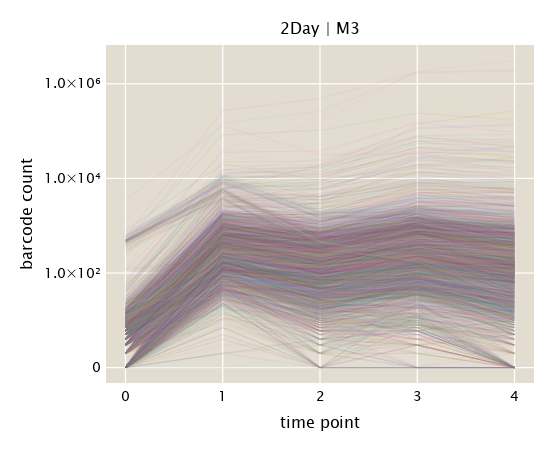

In [138]:
# Define information for data to extract
batch = "Batch4"
hub = "2Day"
perturbation = "M3"
rep = "R1"

# Extract data. Note: The time T0 is common to all perturbations, thus, it must
# be extracted separately as a second condition.
data = df_tidy[
    (
        (df_tidy.hub .== hub) .& 
        (df_tidy.perturbation .== perturbation) .&
        (df_tidy.batch .== batch) .&
        (df_tidy.rep .== rep)
    ) .|
    (
        (df_tidy.hub .== hub) .&
        (df_tidy.timepoint .== "T0") .&
        (df_tidy.batch .== batch)
    ),
:]

# group data by barcode
data_group = DF.groupby(data, :barcode)

# Initialize figure
fig = Figure(resolution=(550, 450))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="time point",
    ylabel="barcode count",
    yscale=Makie.Symlog10(1.0),
    title="$(hub) | $(perturbation)"
)

# Define color palette
colors = ColorSchemes.glasbey_hv_n256

# Loop through trajectories
for bc in data_group
    # Plot trajectory
    lines!(
        bc.time, 
        bc.count, 
        color=(colors[StatsBase.sample(1:length(colors))], 0.05)
    )
end # for

# Add axis ticks
ax.yticks = [[0]; 10 .^(2:2:6)]
fig

The trajectories look reasonable, but because of differences in coverage, it is
hard to tell the trend for each line. Let's plot a naive estimate of the
frequency.

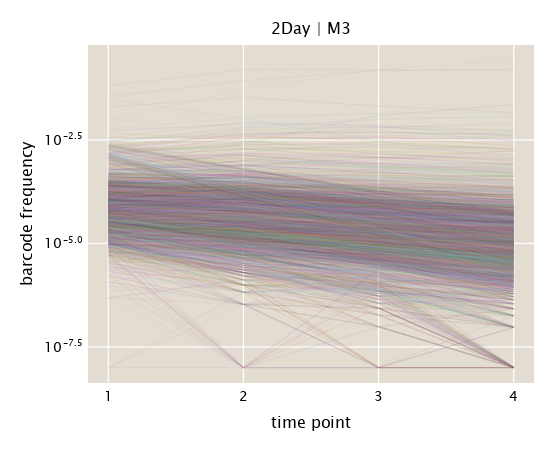

In [164]:
# Define information for data to extract
# Define batch
batch = "Batch4"
hub = "2Day"
perturbation = "M3"
rep = "R1"

# Extract data. Note: The time T0 is common to all perturbations, thus, it must
# be extracted separately as a second condition.
data = df_tidy[
    (
        (df_tidy.hub .== hub) .& 
        (df_tidy.perturbation .== perturbation) .&
        (df_tidy.batch .== batch) .&
        (df_tidy.rep .== rep)
    ), #.|
    # (
    #     (df_tidy.hub .== hub) .&
    #     (df_tidy.timepoint .== "T0") .&
    #     (df_tidy.batch .== batch)
    # ),
:]

# Extract total counts per barcode
count_total = [sum(d.count) for d in DF.groupby(data, :time)]

# group data by barcode
data_group = DF.groupby(data, :barcode)

# Initialize figure
fig = Figure(resolution=(550, 450))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="time point",
    ylabel="barcode frequency",
    yscale=log10,
    title="$(hub) | $(perturbation)"
)

# Define color palette
colors = ColorSchemes.glasbey_hv_n256

# Loop through trajectories
for bc in data_group
    # Plot trajectory
    lines!(
        bc.time, 
        bc.count ./ count_total .+ 1E-8,
        color=(colors[StatsBase.sample(1:length(colors))], 0.05)
    )
end # for

# Add axis ticks
# ax.yticks = [[0]; 10 .^(2:2:6)]
fig

Ignoring time point zero, these trajectories look as expected.

One last thing to finalize the tidy format is to identify the neutral mutants.
These were hand-pick and given on a list. Let's copy and paste such list.

In [165]:
handpicked_neutrals = [
    "CGCTAAAGACATAATGTGGTTTGTTG_TTTTTAAAATGAAACAAGCTTGTATG",
    "CGCTAAAGACATAATGTGGTTTGTTG_ATCTTAAGATAAAAGGCATTTTATTC",
    "CGCTAAAGACATAATGTGGTTTGTTG_ACAGCAACCGTGAATGTACTTCGCAC",
    "CGCTAAAGACATAATGTGGTTTGTTG_AGTATAAGCGCTAAATAATTTTCTCC",
    "CGCTAAAGACATAATGTGGTTTGTTG_AGCATAATCTTTAACACGCTTGTCAG",
    "CGCTAAAGACATAATGTGGTTTGTTG_CCGTTAAAAAGAAATGATTTTTATAG",
    "CGCTAAAGACATAATGTGGTTTGTTG_CCAGTAATTGGAAAACTCCTTGGGAA",
    "CGCTAAAGACATAATGTGGTTTGTTG_ATAGCAACCCAGAAGATCCTTATCTG",
    "CGCTAAAGACATAATGTGGTTTGTTG_CTGAAAAGAGATAAATATTTTACATC",
    "CGCTAAAGACATAATGTGGTTTGTTG_GGAACAAATCAAAATTAATTAACAAA",
    "CGCTAAAGACATAATGTGGTTTGTTG_TAGGAAATTCCAAAGAAATTTGGTAA",
    "CGCTAAAGACATAATGTGGTTTGTTG_GTTAAAAATGAGAAGTCTATTCGCTT",
    "CGCTAAAGACATAATGTGGTTTGTTG_TGGAAAAACGCCAAGGGCGTTTTATC",
    "CGCTAAAGACATAATGTGGTTTGTTG_CTATTAACCGACAATCATCTTAATTT",
    "CGCTAAAGACATAATGTGGTTTGTTG_CATCTAATTGATAACTTCTTTCCCGC",
    "CGCTAAAGACATAATGTGGTTTGTTG_ATGGAAACAAAAAATAGTATTCGCAC",
    "CGCTAAAGACATAATGTGGTTTGTTG_TAAGAAAATCAGAACCGCTTTCAGGG",
    "CGCTAAAGACATAATGTGGTTTGTTG_GCTTTAATGAAAAATTATTTTGGCTG",
    "CGCTAAAGACATAATGTGGTTTGTTG_CTCCTAACCAGTAATAACTTTCTCAA",
    "CGCTAAAGACATAATGTGGTTTGTTG_GTCCAAAACAACAAATGCACTTGCAA",
    "CGCTAAAGACATAATGTGGTTTGTTG_TTTTTAATTTGCAAGGACCTTAGTCT",
    "CGCTAAAGACATAATGTGGTTTGTTG_TGCATAACCTGCAAACAGATTGCCGT",
    "CGCTAAAGACATAATGTGGTTTGTTG_GCATCAATGATCAACGCGGTTACCTG",
    "CGCTAAAGACATAATGTGGTTTGTTG_AGGCTAATACCCAATTCGATTGTCAT",
    "CGCTAAAGACATAATGTGGTTTGTTG_TTTTCAAATAGTAATTGATTTCCAGT",
    "CGCTAAAGACATAATGTGGTTTGTTG_AAGCTAATTGAGAATTATTTTGCATT",
    "CGCTAAAGACATAATGTGGTTTGTTG_TTGCGAATACGTAATTTTGTTGCGGG",
    "CGCTAAAGACATAATGTGGTTTGTTG_CAGTAAACGATCAAATACTTTCAATA",
    "CGCTAAAGACATAATGTGGTTTGTTG_TAACAAATGTCTAATGGAATTTTGCA",
    "CGCTAAAGACATAATGTGGTTTGTTG_GTTGTAATCTCGAAGAGATTTCTAGC",
    "CGCTAAAGACATAATGTGGTTTGTTG_AGAATAAATGAAAAATCATTTAATAT",
    "CGCTAAAGACATAATGTGGTTTGTTG_TCAAAAAATTAAAACCAATTTATCTC",
    "CGCTAAAGACATAATGTGGTTTGTTG_ATACTAAAAAGTAAAGTGGTTATTCT",
    "CGCTAAAGACATAATGTGGTTTGTTG_TACGAAAGCTCTAATGCATTTACAAG",
    "CGCTAAAGACATAATGTGGTTTGTTG_CTCGTAAGCTGTAAGCCTTTTGATTG",
    "CGCTAAAGACATAATGTGGTTTGTTG_CACGTAACGCAGAAGTGCTTTGAAAG",
    "CGCTAAAGACATAATGTGGTTTGTTG_CTACGAACTACGAAATGCCTTGTTTC",
    "CGCTAAAGACATAATGTGGTTTGTTG_GACTAAAACTGTAACATTTTTAATGG",
    "CGCTAAAGACATAATGTGGTTTGTTG_GAGGAAAATTATAACGAATTTTGTCG",
    "CGCTAAAGACATAATGTGGTTTGTTG_CGATTAACTAATAATTCTTTTTAAAG",
    "CGCTAAAGACATAATGTGGTTTGTTG_TTTCCAAATGTAAAGCGTATTCATAC",
    "CGCTAAAGACATAATGTGGTTTGTTG_GGTAGAATATGGAATGTTTTTACGAA",
    "CGCTAAAGACATAATGTGGTTTGTTG_GTGTGAATCAATAAGCATATTGTTTA",
    "CGCTAAAGACATAATGTGGTTTGTTG_TCCCCAACCATTAATTATGTTTACAC",
    "CGCTAAAGACATAATGTGGTTTGTTG_ACCCCAAATACCAAAGGAGTTGCGTG",
    "CGCTAAAGACATAATGTGGTTTGTTG_TCGACAAATTGCAAGAAGGTTTCATC",
    "CGCTAAAGACATAATGTGGTTTGTTG_TCGATAATGACCAATACCATTTTGTC",
    "CGCTAAAGACATAATGTGGTTTGTTG_CGGAAAACATTGAACTTTATTAATGG",
    "CGCTAAAGACATAATGTGGTTTGTTG_AGGGAAAACAGGAAACCCGTTTCCCT",
    "CGCTAAAGACATAATGTGGTTTGTTG_TTTTCAACCGGTAATTAAATTCTCGT",
    "CGCTAAAGACATAATGTGGTTTGTTG_ATTCAAATCGAAAATGATGTTCTTCA",
    "CGCTAAAGACATAATGTGGTTTGTTG_AATAGAACCCCAAATATTTTTTCTCG",
    "CGCTAAAGACATAATGTGGTTTGTTG_TGCTTAAGCGCGAAATGCTTTACACC",
    "CGCTAAAGACATAATGTGGTTTGTTG_CGGCCAATTTGGAAGTCGCTTATATA",
    "CGCTAAAGACATAATGTGGTTTGTTG_TTCATAAACTCTAACAACCTTTTTAG",
    "CGCTAAAGACATAATGTGGTTTGTTG_ACGAGAATAGCAAACGCAGTTGAGCG",
    "CGCTAAAGACATAATGTGGTTTGTTG_GCATCAAGAATAAAGCGGGTTCCGCT",
    "CGCTAAAGACATAATGTGGTTTGTTG_CAAATAATCAAGAACGGCCTTATGTT",
    "CGCTAAAGACATAATGTGGTTTGTTG_AAAGAAAAGCTTAAAGATATTGATGA",
    "CGCTAAAGACATAATGTGGTTTGTTG_CAATCAAGGGTCAATTAACTTTTCAA"
]

60-element Vector{String}:
 "CGCTAAAGACATAATGTGGTTTGTTG_TTTTTAAAATGAAACAAGCTTGTATG"
 "CGCTAAAGACATAATGTGGTTTGTTG_ATCTTAAGATAAAAGGCATTTTATTC"
 "CGCTAAAGACATAATGTGGTTTGTTG_ACAGCAACCGTGAATGTACTTCGCAC"
 "CGCTAAAGACATAATGTGGTTTGTTG_AGTATAAGCGCTAAATAATTTTCTCC"
 "CGCTAAAGACATAATGTGGTTTGTTG_AGCATAATCTTTAACACGCTTGTCAG"
 "CGCTAAAGACATAATGTGGTTTGTTG_CCGTTAAAAAGAAATGATTTTTATAG"
 "CGCTAAAGACATAATGTGGTTTGTTG_CCAGTAATTGGAAAACTCCTTGGGAA"
 "CGCTAAAGACATAATGTGGTTTGTTG_ATAGCAACCCAGAAGATCCTTATCTG"
 "CGCTAAAGACATAATGTGGTTTGTTG_CTGAAAAGAGATAAATATTTTACATC"
 "CGCTAAAGACATAATGTGGTTTGTTG_GGAACAAATCAAAATTAATTAACAAA"
 ⋮
 "CGCTAAAGACATAATGTGGTTTGTTG_AATAGAACCCCAAATATTTTTTCTCG"
 "CGCTAAAGACATAATGTGGTTTGTTG_TGCTTAAGCGCGAAATGCTTTACACC"
 "CGCTAAAGACATAATGTGGTTTGTTG_CGGCCAATTTGGAAGTCGCTTATATA"
 "CGCTAAAGACATAATGTGGTTTGTTG_TTCATAAACTCTAACAACCTTTTTAG"
 "CGCTAAAGACATAATGTGGTTTGTTG_ACGAGAATAGCAAACGCAGTTGAGCG"
 "CGCTAAAGACATAATGTGGTTTGTTG_GCATCAAGAATAAAGCGGGTTCCGCT"
 "CGCTAAAGACATAATGTGGTTTGTTG_CAAATAATCAAGAACGGCCTTATGTT"
 

Next, let's identify which barcodes belong to mutants and add a boolean variable
for this to the tidy dataframe.

In [169]:
# Identify which barcodes belong to neutral lineages
neutral = [bc ∈ handpicked_neutrals for bc in df_tidy.barcode]

# Add boolean column to tidy dataframe
DF.insertcols!(df_tidy, :neutral => neutral)

first(df_tidy, 5)

Row,BCID_x,bc_merged,barcode,barcode_lowcomplexity,barcode_highcomplexity,BCID_y,barcode_fasta,source_publication,cloneID,cloneID_new,evolution_condition,ancestor,class,ploidy,ploidy_new,gene,type,additional_muts,1D_Fitness_Li2019,1D_Error_Li2019,2D_Fitness_Li2019,2D_Error_Li2019,3D_Fitness_Li2019,3D_Error_Li2019,5D_Fitness_Li2019,5D_Error_Li2019,FerPerHour_Li2019,ResPerHour_Li2019,StaPerHour_Li2019,name,count,rep,timepoint,time,batch,hub,perturbation,neutral
,Int64,String,String,String31,String,Int64,String,String15,String31,String?,String7,String15,String31,String15,String15,String31,String?,String?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,String,Int64,String,String,Int64,String,String,String,Bool
1,0,GAGTGAAACATGAATGGTATTCATCATGATCAATCTACAAAAATATTTAATG,TGATCAATCTACAAAAATATTTAATG_GAGTGAAACATGAATGGTATTCATCA,TGATCAATCTACAAAAATATTTAATG,GAGTGAAACATGAATGGTATTCATCA,0,GAGTGAAACATGAATGGTATTCATCATGATCAATCTACAAAAATATTTAATG,This_study,missing,EVO2D_IRA1_MIS_rearray_Plate1-A1,Evo2D,IRA1_MIS,missing,missing,diploid,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,53,R0,T0,0,Batch1,1Day,1Day,false
2,1,ACTCTAACGTGTAACTAATTTTGAGTCCGCCAATCCCGAACCCCGTTTCGCC,CCGCCAATCCCGAACCCCGTTTCGCC_ACTCTAACGTGTAACTAATTTTGAGT,CCGCCAATCCCGAACCCCGTTTCGCC,ACTCTAACGTGTAACTAATTTTGAGT,1,ACTCTAACGTGTAACTAATTTTGAGTCCGCCAATCCCGAACCCCGTTTCGCC,Aggeli2020,gpb2_evo1_plate9_H8,gpb2_evo1_plate9_H8,Evo2D,GPB2,adaptive_haploids,Haploid,Haploid,missing,Other,DOP1-NON_SYNONYMOUS_CODING; SMD2-NON_SYNONYMOUS_CODING; YDL180W-DOWNSTREAM; LAS21-UPSTREAM,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,1213,R0,T0,0,Batch1,1Day,1Day,false
3,2,ATGGGAACACGGAATGATCTTTTATTGACAGAAAAGCCAAATGGATTTACCG,GACAGAAAAGCCAAATGGATTTACCG_ATGGGAACACGGAATGATCTTTTATT,GACAGAAAAGCCAAATGGATTTACCG,ATGGGAACACGGAATGATCTTTTATT,2,ATGGGAACACGGAATGATCTTTTATTGACAGAAAAGCCAAATGGATTTACCG,This_study,missing,EVO3D_TCG_rearray_Plate1-A4,Evo3D,CYR1,missing,missing,diploid,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,17,R0,T0,0,Batch1,1Day,1Day,false
4,3,TACTAAATAAGTAAGGGAATTCTGTTCCAACAAAACACAAATCTGTTGTGTA,CCAACAAAACACAAATCTGTTGTGTA_TACTAAATAAGTAAGGGAATTCTGTT,CCAACAAAACACAAATCTGTTGTGTA,TACTAAATAAGTAAGGGAATTCTGTT,3,TACTAAATAAGTAAGGGAATTCTGTTCCAACAAAACACAAATCTGTTGTGTA,This_study,missing,EVO2D_IRA1_NON_rearray_Plate1-A1,Evo2D,IRA1_NON,missing,missing,diploid,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,19,R0,T0,0,Batch1,1Day,1Day,false
5,4,ATGACAAACTTTAAATAATTTAATTGTATCGAAACCCAAAGAGATTTAATCG,TATCGAAACCCAAAGAGATTTAATCG_ATGACAAACTTTAAATAATTTAATTG,TATCGAAACCCAAAGAGATTTAATCG,ATGACAAACTTTAAATAATTTAATTG,4,ATGACAAACTTTAAATAATTTAATTGTATCGAAACCCAAAGAGATTTAATCG,This_study,missing,EVO3D_IRA1_MIS_rearray_Plate1-C4,Evo3D,IRA1_MIS,missing,missing,haploid,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,23,R0,T0,0,Batch1,1Day,1Day,false


Done! Let's save the dataframe into a `csv` file.

In [171]:
CSV.write("$(git_root())/data/big_batch/tidy_counts.csv", df_tidy)

"/Users/mrazo/git/bayesian_fitness/data/big_batch/tidy_counts.csv"